In [28]:
using SparseArrays

using ReinforcementLearningAnIntroduction
using StatsBase, Plots

In [29]:
ACTIONS = collect(Iterators.flatten((-100:-1, 1:100)))
NS = 1002
NA = length(ACTIONS)

200

Here we define a group mapping preprocessor first.

The first and the last element will be grouped into another two separate group.

In [30]:
Base.@kwdef struct GroupMapping <: AbstractPreprocessor
    n::Int
    n_groups::Int
    n_per_group::Int=div(n, n_groups)
end

function (p::GroupMapping)(x::Int)
    if x == 1
        res = 1
    elseif x == p.n
        res = p.n_groups + 2
    else
        res = div(x - 2, p.n_per_group) + 2
    end
    res
end

And then define a hook to calculate the count of each state.

In [31]:
struct CountStates <: AbstractHook
    counts::Vector{Int}
    CountStates(n) = new(zeros(Int, n))
end

(f::CountStates)(::PreActStage, agent, env, obs, action) = f.counts[get_state(observe(env.env))] += 1

In [32]:
env = RandomWalkEnv(N=NS, actions=ACTIONS)

RandomWalkEnv(1002, 501, 501, [-100, -99, -98, -97, -96, -95, -94, -93, -92, -91  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], -1.0, 1.0, DiscreteSpace{UnitRange{Int64}}(1:1002), DiscreteSpace{UnitRange{Int64}}(1:200))

In [33]:
observe(env)

(state = 501, terminal = false, reward = 0.0)

In [34]:
TRUE_STATE_VALUES = begin
    env = RandomWalkEnv(N=NS, actions=ACTIONS)
    agent = Agent(
        policy=VBasedPolicy(
            learner=TDLearner(
                approximator=TabularApproximator(n_state=NS),
                method=:SRS,
                optimizer=Descent(0.01)
                ),
            mapping=(obs,V) -> begin
                values = zeros(NA)
                values[rand(1:NA)] = 1.0
                values
            end
            ),
        trajectory=EpisodicCompactSARTSATrajectory()
    )
    run(agent, env, StopAfterEpisode(10^5))
    agent.policy.learner.approximator.table
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


1002-element Array{Float64,1}:
  0.0
 -0.9079236280519825
 -0.909762945904959
 -0.9084197831983777
 -0.909213121196942
 -0.8969669823498644
 -0.893906226463185
 -0.8877318712710669
 -0.9120474771052062
 -0.8958841601883387
 -0.8905791245022644
 -0.8853651984642155
 -0.8928960637598029
  ⋮
  0.8906952706413701
  0.8993301315310993
  0.8889446679996388
  0.8838624549211653
  0.8926574802814805
  0.9038478790018427
  0.8926407730584565
  0.9121609634875295
  0.8943391008375321
  0.9152666396867039
  0.9171425109147909
  0.0

In [35]:
using Plots

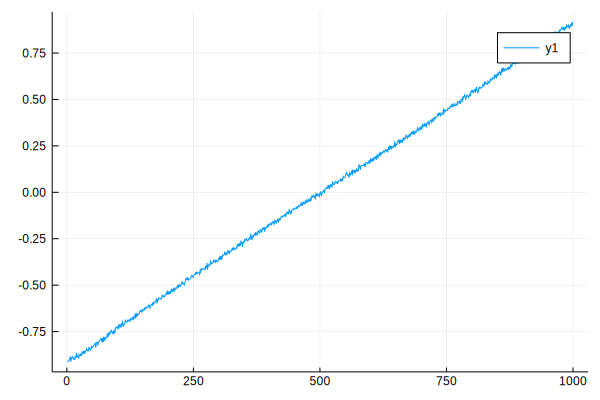

In [36]:
plot(TRUE_STATE_VALUES[2:end-1])

In [37]:
struct RecordRMS <: AbstractHook
    rms::Vector{Float64}
    RecordRMS() = new([])
end

function (f::RecordRMS)(::PostEpisodeStage, agent, env, obs)
    push!(f.rms, sqrt(mean((agent.policy.learner.approximator.(env.preprocessor.(2:(NS-1))) - TRUE_STATE_VALUES[2:end-1]).^2)))
end

In [38]:
n_groups = 10
env = WrappedEnv(
    env=RandomWalkEnv(N=NS, actions=ACTIONS),
    preprocessor=GroupMapping(n=NS, n_groups=n_groups)
    )

WrappedEnv{GroupMapping,RandomWalkEnv,typeof(identity)}(GroupMapping(1002, 10, 100), RandomWalkEnv(1002, 501, 501, [-100, -99, -98, -97, -96, -95, -94, -93, -92, -91  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], -1.0, 1.0, DiscreteSpace{UnitRange{Int64}}(1:1002), DiscreteSpace{UnitRange{Int64}}(1:200)), identity)

In [39]:
agent = Agent(
    policy=VBasedPolicy(
        learner=MonteCarloLearner(
            approximator=TabularApproximator(n_state=n_groups+2),
            kind=EVERY_VISIT,  # this is very important!
            α=2e-5),
        mapping=(obs,V) -> begin
                values = zeros(NA)
                values[rand(1:NA)] = 1.0
                values
            end
        ),
    trajectory=EpisodicCompactSARTSATrajectory()
)

Agent{VBasedPolicy{MonteCarloLearner{ReinforcementLearningAnIntroduction.EveryVisit,TabularApproximator{1,Array{Float64,1}},CachedSampleAvg{Float64},ReinforcementLearningAnIntroduction.NoSampling},var"#38#39",GreedyExplorer},EpisodicCompactSARTSATrajectory{Tuple{Int64,Int64,Float32,Bool,Int64,Int64},Tuple{Array{Float32,1},Array{Bool,1},Array{Int64,1},Array{Int64,1}}},Symbol}(VBasedPolicy{MonteCarloLearner{ReinforcementLearningAnIntroduction.EveryVisit,TabularApproximator{1,Array{Float64,1}},CachedSampleAvg{Float64},ReinforcementLearningAnIntroduction.NoSampling},var"#38#39",GreedyExplorer}(MonteCarloLearner{ReinforcementLearningAnIntroduction.EveryVisit,TabularApproximator{1,Array{Float64,1}},CachedSampleAvg{Float64},ReinforcementLearningAnIntroduction.NoSampling}(TabularApproximator{1,Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), 1.0, 2.0e-5, CachedSampleAvg{Float64}(Dict{Float64,SampleAvg}())), var"#38#39"(), GreedyExplorer()), NamedTuple{(:state, :

In [40]:
hook=CountStates(NS)
run(agent, env, StopAfterEpisode(10^5),hook)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


CountStates([0, 1233, 1213, 1190, 1329, 1349, 1278, 1433, 1346, 1355  …  1285, 1375, 1381, 1365, 1373, 1319, 1333, 1232, 1246, 0])

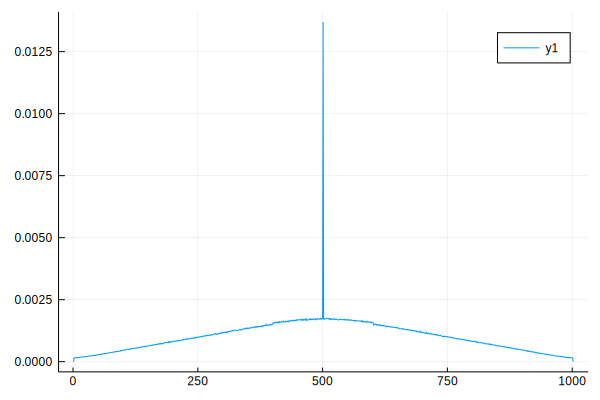

In [41]:
plot(hook.counts./sum(hook.counts))

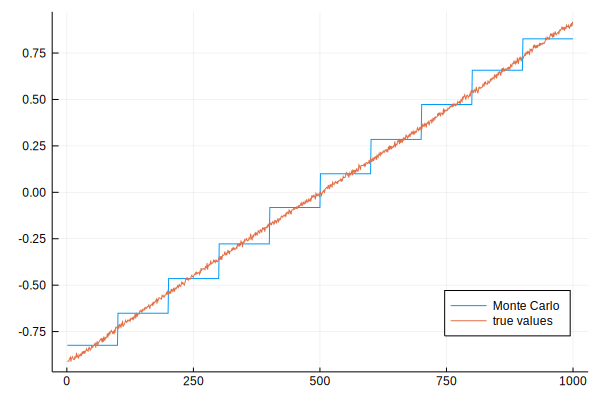

In [42]:
plot(agent.policy.learner.approximator.(env.preprocessor(s) for s in 2:NS-1),legend=:bottomright, label="Monte Carlo")
plot!(TRUE_STATE_VALUES[2:end-1], label="true values")

In [43]:
agent = Agent(
    policy=VBasedPolicy(
        learner=TDLearner(
                approximator=TabularApproximator(n_state=n_groups+2),
                method=:SRS,
                optimizer=Descent(2e-4)
                ),
        mapping=(obs,V) -> begin
                values = zeros(NA)
                values[rand(1:NA)] = 1.0
                values
            end
        ),
    trajectory=EpisodicCompactSARTSATrajectory()
)
run(agent, env, StopAfterEpisode(10^5))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


EmptyHook()

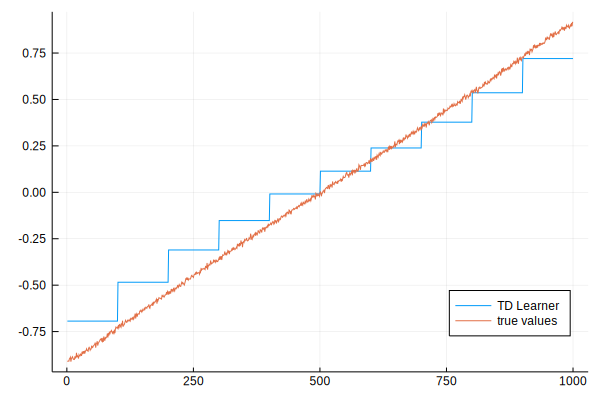

In [44]:
plot(agent.policy.learner.approximator.(env.preprocessor(s) for s in 2:NS-1),legend=:bottomright, label="TD Learner")
plot!(TRUE_STATE_VALUES[2:end-1], label="true values")

In [45]:
using StatsBase

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


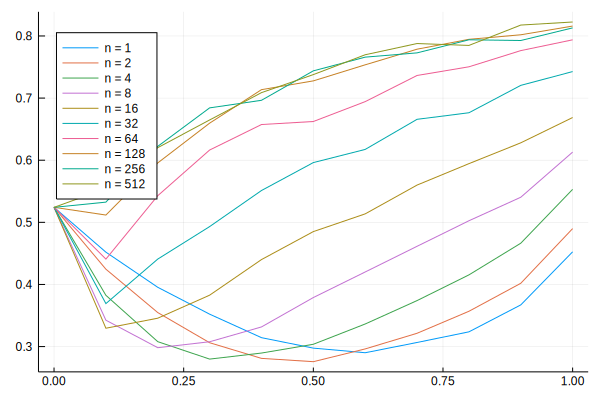

In [46]:
n_groups = 20
function run_once(n, α)
    env = WrappedEnv(
        env=RandomWalkEnv(N=NS, actions=ACTIONS),
        preprocessor=GroupMapping(n=NS, n_groups=n_groups)
        )
    agent = Agent(
        policy=VBasedPolicy(
            learner=TDLearner(
                approximator=TabularApproximator(n_state=n_groups+2),
                method=:SRS,
                optimizer=Descent(α),
                n=n
                ),
            mapping=(obs,V) -> begin
                    values = zeros(NA)
                    values[rand(1:NA)] = 1.0
                    values
                end
            ),
        trajectory=EpisodicCompactSARTSATrajectory()
    )

    hook = RecordRMS()
    run(agent, env, StopAfterEpisode(10),hook)
    mean(hook.rms)
end

A = 0:0.1:1

p = plot(legend=:topleft)
for n in [2^i for i in 0:9]
    plot!(p, A, mean([run_once(n, α) for α in A] for _ in 1:100), label="n = $n")
end
p

In [47]:
struct ScalePreprocessor <: AbstractPreprocessor
    scale::Float64
end

(p::ScalePreprocessor)(x::Number) = p.scale * x

In [48]:
function run_once_MC(preprocessor, order, α)
    env = WrappedEnv(
        env=RandomWalkEnv(N=NS, actions=ACTIONS),
        preprocessor=preprocessor
        )
    
    agent = Agent(
        policy=VBasedPolicy(
            learner=MonteCarloLearner(
                approximator=LinearVApproximator(zeros(order+1)),
                α=α,
                kind=EVERY_VISIT,
                returns = CachedSampleAvg{Vector{Float64}}(),
                ),
            mapping=(obs,V) -> begin
                    values = zeros(NA)
                    values[rand(1:NA)] = 1.0
                    values
                end
            ),
        trajectory=EpisodicCompactSARTSATrajectory(;state_type=Vector{Float64})
    )

    hook=RecordRMS()
    run(agent, env, StopAfterEpisode(5000;is_show_progress=false),hook)
    hook.rms
end

run_once_MC (generic function with 1 method)

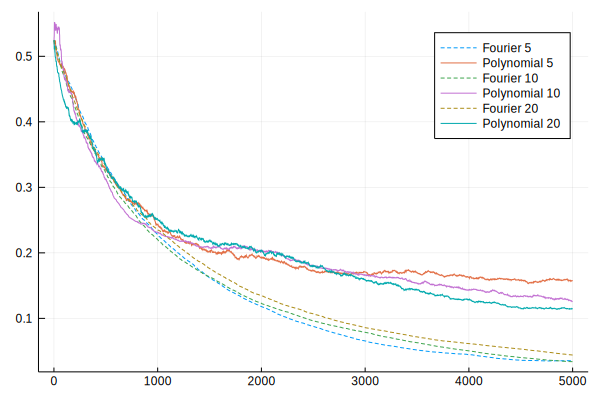

In [49]:
p = plot(legend=:topright)
for order in [5, 10, 20]
    plot!(p, mean(run_once_MC(ComposedPreprocessor(ScalePreprocessor(1/NS), FourierPreprocessor(order)), order, 0.00005) for _ in 1:1), label="Fourier $order", linestyle=:dash)
    plot!(p, mean(run_once_MC(ComposedPreprocessor(ScalePreprocessor(1/NS), PolynomialPreprocessor(order)), order, 0.0001) for _ in 1:1), label="Polynomial $order", linestyle=:solid)
end
p

In [50]:
function run_once_MC(preprocessor, α, V)
    env = WrappedEnv(
        env=RandomWalkEnv(N=NS, actions=ACTIONS),
        preprocessor=preprocessor
        )
    
    agent = Agent(
        policy=VBasedPolicy(
            learner=MonteCarloLearner(
                approximator=LinearVApproximator(V),
                α=α,
                kind=EVERY_VISIT,
                returns = CachedSampleAvg{SparseMatrixCSC{Float64,Int64}}(),
                ),
            mapping=(obs,V) -> begin
                    values = zeros(NA)
                    values[rand(1:NA)] = 1.0
                    values
                end
            ),
        trajectory=EpisodicCompactSARTSATrajectory(;state_type=SparseMatrixCSC{Float64,Int64})
    )

    hook=RecordRMS()
    run(agent, env, StopAfterEpisode(10000;is_show_progress=false),hook)
    hook.rms
end

run_once_MC (generic function with 1 method)

In [51]:
struct ToSparseMatrixPreprocessor <: AbstractPreprocessor
    m::Int
    n::Int
end

(p::ToSparseMatrixPreprocessor)(xs::Vector{Int}) = sparse(xs, 1:length(xs), ones(length(xs)), p.m, p.n)

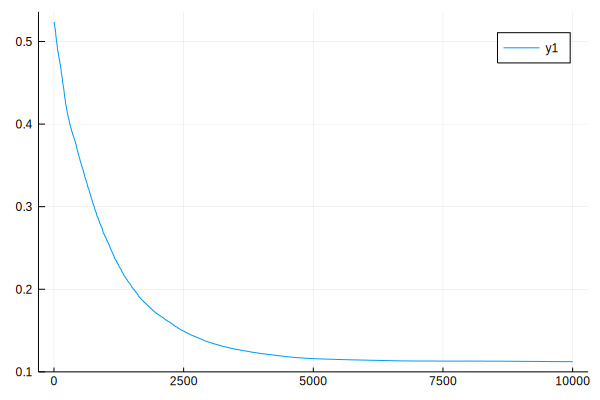

In [52]:
plot(run_once_MC(
    ComposedPreprocessor(
        TilingPreprocessor([Tiling((range(1-4*(i-1), step=200, length=7),)) for i in 1:1]),
        ToSparseMatrixPreprocessor(7, 1)
        ),
    1e-4/1,
    zeros(7,1)))

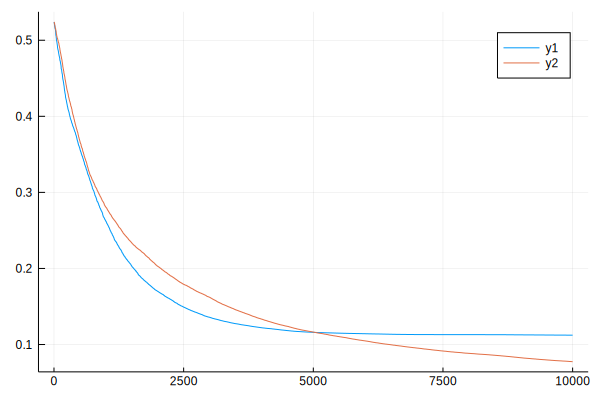

In [53]:
plot!(run_once_MC(
    ComposedPreprocessor(
        TilingPreprocessor([Tiling((range(1-4*(i-1), step=200, length=7),)) for i in 1:50]),
        ToSparseMatrixPreprocessor(7, 50)
        ),
    1e-4/50,
    zeros(7,50)))